# Image Classification

This jupyter notebook will guide you through the image classification pipeline for a webcrawler based seal detector. ***Be warned: you will need a GPU with 8gb or more memory to run most parts of this script***


## Table of contents
1. [Getting started](#getting_started)
2. [Visualizing training images](#vis_imgs)
3. [Training](#train)
4. [Validation](#val)
5. [Prediction](#pred)



## Getting Started<a name="getting_started"></a>

Training images should be manually classified and divided into training and validation set. The resulting folder, with training and validation folders and a subfolder for each class, should be moved into the './training_sets' folder. Finally, in order to be recognized by the training and validation scripts we must add an entry for the new training set, with the folder name and number of classes contained, to the training_sets dictionary inside *model_library.py*. To load required packages and global variables, run the following cell.  

In [2]:
# import required packages
import os
import rasterio
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import matplotlib as mpl
from functools import reduce
from utils.model_library import * 
import warnings

# prevents a flood of warnings from pandas
warnings.filterwarnings(action='once')

%matplotlib inline
mpl.rcParams['figure.dpi']= 400

# display class names
class_names = sorted([subdir for subdir in os.listdir('./training_sets/training_set_13_MAY_18/training')])
print(class_names)

['NonSeal', 'crabeater', 'elephant', 'fur', 'harp', 'leopard', 'other-seal', 'ross', 'weddell']


## Visualizing training images (Optional)<a name="vis_imgs"></a>

To get a better sense for what the training set is like, the next cell will display a few random images from the training set.

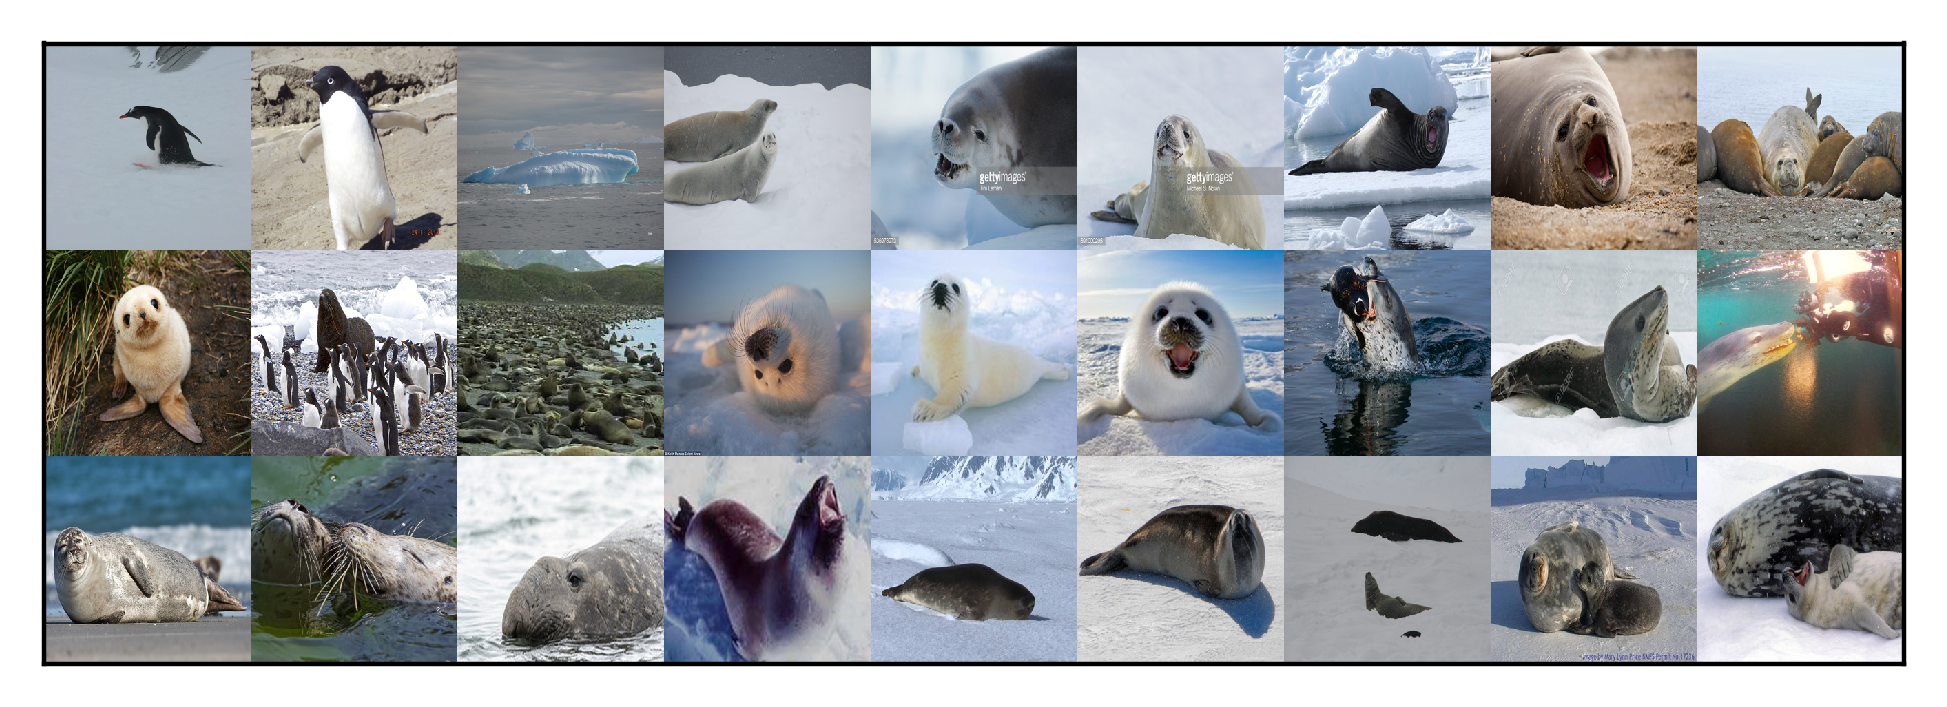

In [19]:
# store images
images = np.empty([len(class_names) * 3, 300, 300, 3], dtype=np.uint8)


# loop over labels
idx = 0
for label in class_names:
    for path, _, files in os.walk('./training_sets/training_set_13_MAY_18/training/{}'.format(label)):
        files = np.random.choice(files, 3)
        for filename in files:
            img = Image.open(os.path.join(path, filename)).convert('RGB')
            # resize image
            img = img.resize([300, 300], Image.ANTIALIAS)
            img = np.array(img)
            images[idx, :, :, :] = img
            idx += 1

# display images 
ncols=len(class_names)
nindex, height, width, intensity = images.shape
nrows = nindex//ncols
assert nindex == nrows*ncols
result = (images.reshape(nrows, ncols, height, width, intensity)
          .swapaxes(1,2)
          .reshape(height*nrows, width*ncols, intensity))

plt.imshow(result)
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.show()

## Training<a name="train"></a>

#### Preprocessing 

Before we get started with training we have to run a script that removes all images that are incompatible with the training. After ensuring that your directory structure is as described above, you can run the following script:

In [ ]:
%run ./prep_train.py

### Define model combinations

You should now be ready to train CNNs to classify seals. The following cell will generate a combination of model architectures and hyperparameters that we will then train and validate. Valid combinations of models, hyperparameter sets and training sets can be found in *model_library.py* within './utils'. Trained models are saved in the './saved_models' directory under the root folder for this repository. 

In [3]:
# generate model combinations
model_combinations = {'model_architecture': ['Resnet18', 'Resnet34', 'Resnet50', 'Squeezenet11', 'Densenet121', 'Densenet169', 'Alexnet', 'VGG16'], 
                     'training_dir': ['training_set_13_MAY_18'] * 8,
                     'hyperparameter_set': ['D'] * 8,
                     'output_name': ['Resnet18', 'Resnet34', 'Resnet50', 'Squeezenet11', 'Densenet121', 'Densenet169', 'Alexnet', 'VGG16']}

model_combinations = pd.DataFrame(model_combinations)

# create folders for resulting files
for mdl in model_combinations['output_name']:
    if not os.path.exists("./saved_models/{}".format(mdl)):
        os.makedirs("./saved_models/{}".format(mdl)) 

### Train models

Running the following cell will loop through model combinations, check if they have already been trained and train that combination otherwise. The training script, *train_classifier.py* works with an argument parser, so we need to pass the python variables (place a $ before the python variable when calling the script) from the model_combinations DataFrame as bash variables in order to train.

In [4]:
# iterate over combinations
for row in model_combinations.iterrows():
    t_dir, arch, hyp_st, out = row[1]['training_dir'], row[1]['model_architecture'], row[1]['hyperparameter_set'], row[1]['output_name']
    # check if model is already trained
    if "{}.tar".format(out) in os.listdir('./saved_models/{}/'.format(out)): 
        print('{} was already trained'.format(out))
        continue
    
    print()
    !echo training $out
    print()
    
    # run training
    %run train_classifier.py --training_dir=$t_dir --model_architecture=$arch --hyperparameter_set=$hyp_st --output_name=$out

Resnet18 was already trained
Resnet34 was already trained
Resnet50 was already trained
Squeezenet11 was already trained
Densenet121 was already trained
Densenet169 was already trained
Alexnet was already trained
VGG16 was already trained


## Validation<a name="val"></a> 

### Getting raw results

With models trained, it is now time to validate our models so we can have more insight on which model we should pick for a final pipeline. The following cell runs model combinations through a validation set using *validate_classifier.py*, keeping classifications, number of model parameters and running time in a .csv file. 

In [5]:
# iterate over combinations
for row in model_combinations.iterrows():
    t_dir, arch, hyp_st, out = row[1]['training_dir'], row[1]['model_architecture'], row[1]['hyperparameter_set'], row[1]['output_name']
    # check if model is already trained
    if "{}.tar".format(out) not in os.listdir('./saved_models/{}/'.format(out)): 
        print('{} was not trained yet'.format(out))
        continue
    
    print()
    !echo Validating $out 
    print()
    
    # run training
    %run validate_classifier.py --training_dir=$t_dir --model_architecture=$arch --hyperparameter_set=$hyp_st --model_name=$out


Validating Resnet18



/home/bento/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


Validation complete in 0.0h 0m 24s
Validation Acc: 0.712968

Validating Resnet34

Validation complete in 0.0h 0m 14s
Validation Acc: 0.690179

Validating Resnet50

Validation complete in 0.0h 0m 26s
Validation Acc: 0.655453

Validating Squeezenet11



/home/bento/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/home/bento/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


Validation complete in 0.0h 0m 11s
Validation Acc: 0.551275

Validating Densenet121



/home/bento/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Validation complete in 0.0h 0m 29s
Validation Acc: 0.768855

Validating Densenet169



/home/bento/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Validation complete in 0.0h 0m 35s
Validation Acc: 0.716224

Validating Alexnet

Validation complete in 0.0h 0m 10s
Validation Acc: 0.120998

Validating VGG16

Validation complete in 0.0h 0m 46s
Validation Acc: 0.457406


### Plotting results

Finally, we can import results obtained in the cell above into two R scripts to generate confusion matrices for each model and model comparison plots with accuracy / performance tradeoffs between different models. Plots are saved as png files within the 'saved_models' folder and subfolders. 

In [12]:
# accumulate statistics for model comparison
comb_stats = pd.DataFrame()

# get class names argument
lbls = '_'.join(class_names)

# iterate over combinations
for row in model_combinations.iterrows():
    out = row[1]['output_name']
    # plot confusion matrix and extract performance metrics
    !Rscript plot_confusion_matrix.R $out $lbls
    comb_stats = comb_stats.append(pd.read_csv('./saved_models/{}/{}_model_stats.csv'.format(out, out)), ignore_index=True)
    
# save combined model stats and plot model comparisons
comb_stats.to_csv('./saved_models/pooled_model_stats.csv')
!Rscript plot_comparison.R './saved_models/pooled_model_stats.csv'
   

Loading required package: methods
Loading required package: methods
Loading required package: methods
Loading required package: methods
Loading required package: methods
Loading required package: methods
Loading required package: methods
Loading required package: methods
Loading required package: methods
null device 
          1 
null device 
          1 


## Prediction<a name="pred"></a>

### Pre-processing 

At this point you should have an already trained/saved model from the previous section. It is important that you run the code in the "Getting Started" section so that the class_names variable is properly populated. New images that you want to make predictions on can be in any directory structure, as long as the root directory is ./images.

Run the following code to create the directory structure for the output of your predictions:

In [13]:
%mkdir classified_images
for x in class_names:
    dir = './classified_images/' + x
    %mkdir -v $dir

mkdir: created directory './classified_images/NonSeal'
mkdir: created directory './classified_images/crabeater'
mkdir: created directory './classified_images/elephant'
mkdir: created directory './classified_images/fur'
mkdir: created directory './classified_images/harp'
mkdir: created directory './classified_images/leopard'
mkdir: created directory './classified_images/other-seal'
mkdir: created directory './classified_images/ross'
mkdir: created directory './classified_images/weddell'


***Warning: running the following cell will remove all images without GPS locations***

To prevent errors and to save time, we want to first remove all images that aren't compatible with the libraries used to make predictions, and any images that don't have the metadata we want. After running the following script, the only images remaining should be those that are compatible and contain metadata:

In [ ]:
%run prep_predict.py

### Making predictions

Finally, you can make predictions on unclassified images. The following cell looks for all valid images in the './to_classify' folder, classifies them with Densenet121 and saves assigned labels and file names to a csv file within './classified_images'

In [29]:
%run predict_images.py --training_dir='training_set_13_MAY_18' --model_architecture='Densenet121' --hyperparameter_set='D' --model_name='Densenet121' --data_dir='./to_classify'

/home/bento/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


We can then move all classified images in the .csv file to subfolders of classified images

In [36]:
classified = pd.read_csv('./classified_images/classified.csv')

for path, _, filenames in os.walk('./to_classify'):
    for file in filenames:
        file_path = os.path.join(path, file)
        print(classified.loc[classified['file']==file]['label'])
        target_file = './classified_images/{}/{}'.format(classified.loc[classified['file']==file]['label'], file)
        img = Image.open(file_path)
        img.save(target_file)


0    weddell
Name: label, dtype: object


FileNotFoundError: [Errno 2] No such file or directory: './classified_images/0    weddell\nName: label, dtype: object/weddeee.jpeg'